# AgroChill - Model Performance Analysis

## Data Processing

In [55]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.utils.callbacks import TFMProgressBar
import matplotlib.pyplot as plt
import torch
import numpy as np

In [35]:
weather_df = pd.read_csv("./Datasets/WeatherData/train_data.csv")
price_df = pd.read_csv("./Datasets/PriceData/train_data.csv")

 # Parse dates
price_df['Date'] = pd.to_datetime(price_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Mergre the two datasets on the date and region columns
weather_agg = weather_df.groupby(['Region', 'Date']).mean().reset_index()
full_df = pd.merge(price_df, weather_agg, on=['Region', 'Date'], how='left')

full_df

,Date,Region,Commodity,Price per Unit (Silver Drachma/kg),Type,Temperature (K),Rainfall (mm),Humidity (%),Crop Yield Impact Score
0,2040-01-01,Mystic Falls,Plantain,296.37,Fruit,307.55,474.5,61.3,1.89
1,2040-01-01,Olympus,Loquat,394.21,Fruit,301.35,106.6,53.6,1.74
2,2040-01-01,Metropolis,Loquat,308.13,Fruit,306.15,266.3,93.9,2.18
3,2040-01-01,Arcadia,Loquat,460.81,Fruit,304.15,222.2,81.0,1.68
4,2040-01-01,Elysium,Loquat,85.58,Fruit,304.85,492.1,61.7,1.89
...,...,...,...,...,...,...,...,...,...
181725,2043-06-30,Shangri-La,Butternut Squash,189.08,Vegetable,296.55,427.5,54.5,1.91
181726,2043-06-30,Asgard,Sweet Potato,387.87,Vegetable,304.95,44.7,71.7,1.52
181727,2043-06-30,Rivendell,Butternut Squash,320.00,Vegetable,306.05,281.7,83.4,0.61
181728,2043-06-30,Winterfell,Butternut Squash,360.21,Vegetable,297.85,20.0,92.2,0.68


In [36]:
# Remove duplicates
full_df = full_df.drop_duplicates(subset=['Region', 'Date','Commodity'])
full_df

,Date,Region,Commodity,Price per Unit (Silver Drachma/kg),Type,Temperature (K),Rainfall (mm),Humidity (%),Crop Yield Impact Score
0,2040-01-01,Mystic Falls,Plantain,296.37,Fruit,307.55,474.5,61.3,1.89
1,2040-01-01,Olympus,Loquat,394.21,Fruit,301.35,106.6,53.6,1.74
2,2040-01-01,Metropolis,Loquat,308.13,Fruit,306.15,266.3,93.9,2.18
3,2040-01-01,Arcadia,Loquat,460.81,Fruit,304.15,222.2,81.0,1.68
4,2040-01-01,Elysium,Loquat,85.58,Fruit,304.85,492.1,61.7,1.89
...,...,...,...,...,...,...,...,...,...
181725,2043-06-30,Shangri-La,Butternut Squash,189.08,Vegetable,296.55,427.5,54.5,1.91
181726,2043-06-30,Asgard,Sweet Potato,387.87,Vegetable,304.95,44.7,71.7,1.52
181727,2043-06-30,Rivendell,Butternut Squash,320.00,Vegetable,306.05,281.7,83.4,0.61
181728,2043-06-30,Winterfell,Butternut Squash,360.21,Vegetable,297.85,20.0,92.2,0.68


In [37]:
full_df['RoundedDate'] = pd.to_datetime(full_df['Date']).dt.to_period('W').apply(lambda r: r.start_time)
# Exclude non-numeric columns before applying the mean function
agg_df = full_df.groupby(['Region', 'Commodity', 'RoundedDate']).agg(
    {col: 'mean' for col in full_df.select_dtypes(include='number').columns}
).reset_index()

def ensure_weekly_continuity(group):
    
    full_range = pd.date_range(start=group['RoundedDate'].min(),
                               end=group['RoundedDate'].max(),
                               freq='7D')
    return group.set_index('RoundedDate').reindex(full_range).rename_axis('RoundedDate').reset_index()

fixed_df = agg_df.groupby(['Region', 'Commodity']).apply(ensure_weekly_continuity).reset_index(drop=True)
fixed_df

/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/1263884646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['RoundedDate'] = pd.to_datetime(full_df['Date']).dt.to_period('W').apply(lambda r: r.start_time)
/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/1263884646.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fixed_df = agg_df.groupby(['Region', 'Commodity']).apply(ensure_weekly_continuity).reset_index(drop

,RoundedDate,Region,Commodity,Price per Unit (Silver Drachma/kg),Temperature (K),Rainfall (mm),Humidity (%),Crop Yield Impact Score
0,2040-01-02,Arcadia,Amaranth Leaves,283.89,304.150000,222.200000,81.000000,1.680000
1,2040-01-09,Arcadia,Amaranth Leaves,278.76,294.650000,173.100000,60.000000,2.100000
2,2040-01-16,Arcadia,Amaranth Leaves,98.04,293.950000,276.000000,81.800000,0.760000
3,2040-01-23,Arcadia,Amaranth Leaves,489.30,306.950000,444.600000,95.400000,1.030000
4,2040-01-30,Arcadia,Amaranth Leaves,61.76,300.450000,358.300000,52.400000,2.080000
...,...,...,...,...,...,...,...,...
168775,2043-05-25,Zion,Yam,295.96,302.550000,150.900000,50.600000,0.750000
168776,2043-06-01,Zion,Yam,517.03,309.583333,461.166667,52.433333,1.743333
168777,2043-06-08,Zion,Yam,412.40,310.050000,166.900000,71.100000,0.960000
168778,2043-06-15,Zion,Yam,135.68,307.750000,98.000000,73.800000,1.200000


In [38]:
# Get the data only for Arcadia Region and the Feijoa commodity
arcadia_df = fixed_df[(fixed_df['Region'] == 'Arcadia') & (fixed_df['Commodity'] == 'Feijoa')]
arcadia_df

,RoundedDate,Region,Commodity,Price per Unit (Silver Drachma/kg),Temperature (K),Rainfall (mm),Humidity (%),Crop Yield Impact Score
2189,2040-01-02,Arcadia,Feijoa,195.630,304.15,222.20,81.00,1.680
2190,2040-01-09,Arcadia,Feijoa,269.660,294.30,224.55,70.90,1.430
2191,2040-01-16,Arcadia,Feijoa,288.240,306.95,444.60,95.40,1.030
2192,2040-01-23,Arcadia,Feijoa,122.070,302.85,128.40,62.90,2.090
2193,2040-01-30,Arcadia,Feijoa,204.710,300.45,358.30,52.40,2.080
...,...,...,...,...,...,...,...,...
2366,2043-05-25,Arcadia,Feijoa,496.580,293.35,27.80,48.90,1.470
2367,2043-06-01,Arcadia,Feijoa,445.885,302.95,262.30,72.55,1.325
2368,2043-06-08,Arcadia,Feijoa,280.470,303.05,368.00,92.20,0.640
2369,2043-06-15,Arcadia,Feijoa,204.550,309.05,167.10,70.20,1.630


In [39]:
# Step 3: Fill missing weeks using reindexing
def enforce_weekly_frequency(group):
    full_range = pd.date_range(start=group['RoundedDate'].min(),
                               end=group['RoundedDate'].max(),
                               freq='7D')  # Exact 7-day intervals
    group = group.set_index('RoundedDate').reindex(full_range)
    group['Region'] = group['Region'].fillna(method='ffill')
    group['Commodity'] = group['Commodity'].fillna(method='ffill')
    group = group.rename_axis('RoundedDate').reset_index()
    return group

# Apply per (Region, Commodity)
fixed_df = agg_df.groupby(['Region', 'Commodity']).apply(enforce_weekly_frequency).reset_index(drop=True)


fixed_df['DateDiff'] = fixed_df.groupby(['Region', 'Commodity'])['RoundedDate'].diff().dt.days
fixed_df['DateDiff'].value_counts()

/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/2233027274.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['Region'] = group['Region'].fillna(method='ffill')
/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/2233027274.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['Commodity'] = group['Commodity'].fillna(method='ffill')
/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/2233027274.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['Region'] = group['Region'].fillna(method='ffill')
/var/folders/n9/mmqk74cn5jn_6_4g79lmp2y00000gp/T/ipykernel_60378/2233027274.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future versio

DateDiff
7.0    167855
Name: count, dtype: int64

## Creating time series

In [40]:
fixed_df = fixed_df.fillna(fixed_df.mean(numeric_only=True))

y_all = TimeSeries.from_group_dataframe(fixed_df,
                                  group_cols=['Region','Commodity'],
                                  time_col='RoundedDate',
                                  value_cols=['Price per Unit (Silver Drachma/kg)'],
                                  freq='7D')

past_cov_all = TimeSeries.from_group_dataframe(fixed_df,
                                           group_cols=['Region','Commodity'],
                                           time_col='RoundedDate',
                                           value_cols=['Crop Yield Impact Score'],
                                           freq='7D') 


# Scale the data
y_scaler, past_cov_scaler = Scaler(), Scaler()
y_train_scaled = y_scaler.fit_transform(y_all)
past_cov_train_scaled = past_cov_scaler.fit_transform(past_cov_all)



## Training

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=4,
    n_epochs=100,
    random_state=0,
    **generate_torch_kwargs(),
)

# Fit the model with the extended past_covariates
model.fit(y_train_scaled[5], past_cov_train_scaled[5])

model.save("./test_models/nbeats_model")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.539    Total estimated model params size (MB)
396       Modules in train mod

Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s, train_loss=0.000774]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 14.33it/s, train_loss=0.000774]


## Predicting

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=925) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.


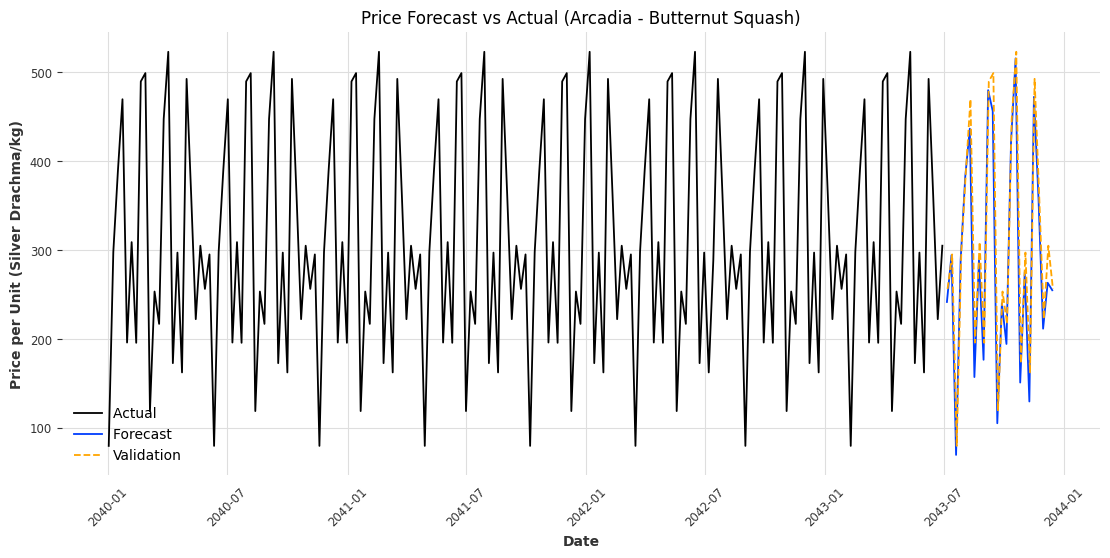

In [ ]:
loaded_model = NBEATSModel.load("./test_models/nbeats_model")

# Get the series index for given commodity and region
def predict(region, commodity):
    for i, series in enumerate(y_all):
        if series.static_covariates['Region'].iloc[0] == region and series.static_covariates['Commodity'].iloc[0] == commodity:
            # Extend the past covariates to cover the required time range
            new_time_index = pd.date_range(
                start=past_cov_train_scaled[i].time_index[-1] + past_cov_train_scaled[i].freq,
                periods=24,
                freq=past_cov_train_scaled[i].freq,
            )
            new_values = np.tile(past_cov_train_scaled[i].values()[-1], (24, 1))

            extended_past_cov = past_cov_train_scaled[i].append(
                TimeSeries.from_times_and_values(new_time_index, new_values)
            )
            y_pred = loaded_model.predict(n=24, series=y_train_scaled[i], past_cov_train_scaled=extended_past_cov)
            # Inverse transform the prediction
            y_pred = y_scaler.inverse_transform(y_pred)
            return y_pred
    return None
# Predict the next 24 days for the first series in y_all


# Plot actual time series
actual_series = y_all[5].to_dataframe()
plt.plot(actual_series.index, actual_series.iloc[:, 0], label='Actual ')

# Forecast
forecast = predict("Arcadia", "Butternut Squash")
forecast_df = forecast.to_dataframe()
plt.plot(forecast_df.index, forecast_df.iloc[:, 0], label='Forecast ')

# Validation data
eval_df = pd.read_csv("./Datasets/PriceData/eval_data.csv")
eval_df['Date'] = pd.to_datetime(eval_df['Date'])
# Filter for Arcadia and Butternut Squash
eval_filtered = eval_df[(eval_df['Region'] == "Arcadia") & (eval_df['Commodity'] == "Butternut Squash")]
eval_filtered = eval_filtered.sort_values('Date').head(24)

plt.plot(eval_filtered['Date'], eval_filtered['Price per Unit (Silver Drachma/kg)'],
         label='Validation' , linestyle='--', color='orange')

plt.title("Price Forecast vs Actual (Arcadia - Butternut Squash)")
plt.xlabel("Date")
plt.ylabel("Price per Unit (Silver Drachma/kg)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.gcf().set_size_inches(12, 6)

plt.show()

## Calculating RMSE

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/induwarag/DataCrunch/Data_Crunch_045_Finals/venv/lib/python3.13/site-packages/t

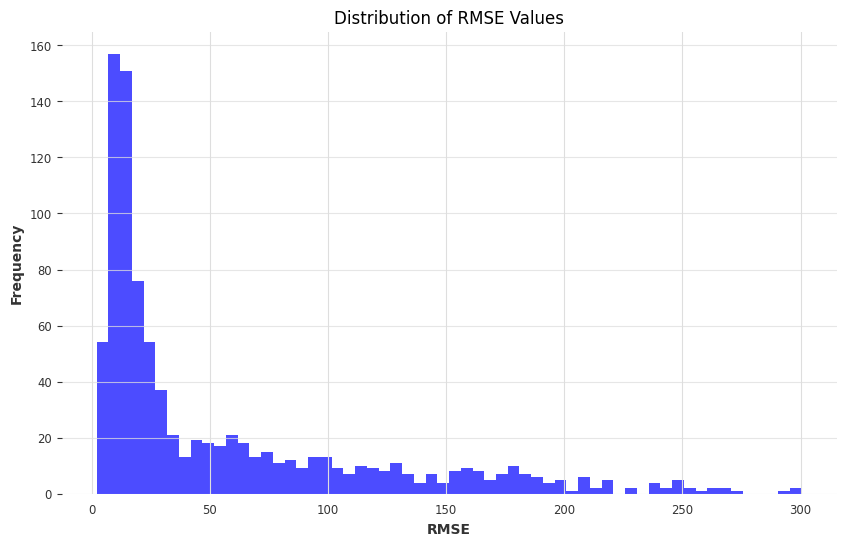

count    925.000000
mean      55.981418
std       62.949578
min        2.086860
25%       12.616102
50%       24.271516
75%       80.824895
max      300.311302
Name: RMSE, dtype: float64

In [56]:
y_pred_all = loaded_model.predict(n=4, series=y_train_scaled)  
def calculate_rmse_per_model(y_all, y_scaler, eval_path="./Datasets/PriceData/eval_data.csv"):
    # Load and process evaluation data
    eval_df = pd.read_csv(eval_path)
    eval_df['Region'] = eval_df['Region'].astype(str)
    eval_df['Commodity'] = eval_df['Commodity'].astype(str)

    # De-normalize predictions

    y_pred_all = loaded_model.predict(n=4, series=y_train_scaled)  
    y_pred_all = y_scaler.inverse_transform(y_pred_all)

    rmse_results = []

    for i, series in enumerate(y_pred_all):
        # Extract metadata
        region = y_all[i].static_covariates['Region'].iloc[0]
        commodity = y_all[i].static_covariates['Commodity'].iloc[0]

        # Get actual prices for the group
        actual_group = eval_df[(eval_df['Region'] == region) & (eval_df['Commodity'] == commodity)]
        actual_prices = actual_group['Price per Unit (Silver Drachma/kg)'].values[:4]

        if len(actual_prices) < 4:
            continue  # Skip if not enough data

        predicted_values = series.values()[:4].flatten()

        # Calculate RMSE
        rmse = np.sqrt(np.mean((predicted_values - actual_prices) ** 2))

        rmse_results.append({
            'Region': region,
            'Commodity': commodity,
            'RMSE': rmse
        })

    return pd.DataFrame(rmse_results)

# Example usage
rmse_df = calculate_rmse_per_model(y_all, y_scaler)

# Plot the distribution of RMSE values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(rmse_df['RMSE'], bins=60, color='blue', alpha=0.7)
plt.title('Distribution of RMSE Values')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

rmse_df['RMSE'].describe()
